Quantum key distribution (QKD) is a secure communication method which implements a cryptographic protocol involving components of quantum mechanics. It enables two parties to produce a shared random secret key known only to them, which can then be used to encrypt and decrypt messages.

### Import modules

In [1]:
import qiclib as ql
from qiclib.code import *

from qiclib.packages.qiskit.QiController_backend import QiController_backend
from qiclib.packages.qiskit.QiController_provider import QiController_provider

import matplotlib.pyplot as plt

import numpy as np

from numpy.random import randint

/home/sbenrached/.local/lib/python3.6/site-packages/qiskit/__init__.py:66: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of qiskit-terra 0.17.0. Support for running Qiskit with Python 3.6 will be removed in qiskit-terra 0.20.0.
  DeprecationWarning,


### Call QiController backend Slot3

In [2]:
qic = ql.QiController('slot3-platform')

Platform driver version: v0.1.0 +602 (1a5496ef, 03.12.2021 15:47)
Establishing gRPC connection to slot3-platform:50058...
Standard Qubit-Platform running on ZCU111 board
QiController firmware built 2021-12-02 17:01:46 (rev. 714)
Firmware with 3 digital unit cells detected.


### Define the sample

In [3]:
# Define the sample of 3 cells; 2 cells correspond the 2 qubits of the circuit, and the 3rd cell is used
# for coupling q0 and q1
sample = QiCells(1) 

# First cell corresponds to the first qubit of the circuit
sample[0]["rec_pulse"] = 116e-9 # s readout pulse length
sample[0]["rec_length"] = 100e-9 # s recording window size
sample[0]["rec_frequency"] = 60e6 # Hz readout pulse frequency
sample[0]["manip_frequency"] = 80e6 # Hz control pulse frequency
sample[0]["rec_offset"] = 20e-9 # s electrical delay
sample[0]["pi"] = 160e-9 # s Pi pulse duration
sample[0]["T1"] = 2e-6 # s decoherence time
sample[0]["T2"] = 3e-6 # s dephasing time

### Amplitude calibration

In [4]:
qic.cell[0].manipulation.amplitude_calibration = (0.5,0.5)
qic.cell[1].manipulation.amplitude_calibration = (0.5,0.5)

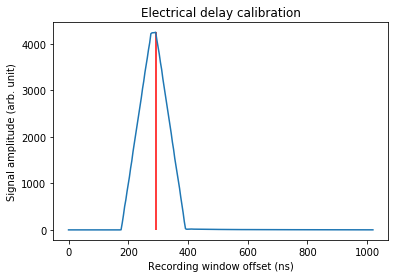

Optimal offset: 292.0 ns
Mirror sideband is 14.5 dB suppressed at recording input


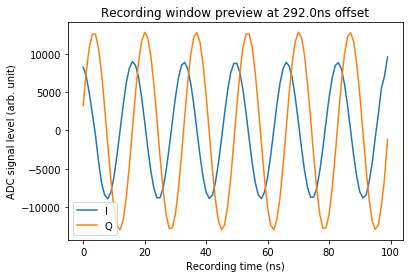

In [5]:
ql.init.calibrate_readout(qic, sample, averages=1000)

In [6]:
with QiJob() as job_test:
    
    q = QiCells(1)
    
    ql.jobs.Readout(q[0], "result")
    
job_test.run(qic, sample, averages=1000, data_collection="iqcloud")

In [7]:
result = job_test.cells[0].data("result")

### State calibration

In [8]:
from qiclib.packages.utility import calculate_stater_config

# Enter the coordinates of the seperation line to each cell of the sample seperately
qic.cell[0].recording.state_config = calculate_stater_config(-4560, -1280, -4530, -1270)
qic.cell[1].recording.state_config = calculate_stater_config(-4560, -1280, -4530, -1270)

### Call QiController provider and define backend

In [9]:
# Call the QiController hardware provider with the specified sample
provider = QiController_provider(qic, sample)

In [10]:
# Create a backend based on the given hardware provider and the sample
backend = QiController_backend(provider)

### QKD Protocol

### Step 1

Alice chooses a string of random bits, e.g.:

1000101011010100

In [11]:
from qiskit import QuantumCircuit

In [12]:
np.random.seed()
n = 100
## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)
print(alice_bits)

[1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0
 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 1]


### Step 2

Alice generates a random choice of basis for each bit .e.g:

ZZXZXXXZXZXXXXXX

Alice keeps the information on the string of bits and the string of basis private to herself.

Alice then encodes each bit onto a string of qubits using the basis she chose; this means each qubit is in one of the states |0⟩, |1⟩, |+⟩ or |−⟩, chosen at random. 

If the bit is 0 and the corresponding basis bit is 0, then the bit is encoded as |0⟩ in the Z-basis.
If the bit is 1 and the corresponding basis bit is 0, then the bit is encoded as |1⟩ in the Z-basis.

If the bit is 0 and the corresponding basis bit is 1, then the bit is encoded as |+⟩ in the X-basis.
If the bit is 1 and the corresponding basis bit is 1, then the bit is encoded as |−⟩ in the X-basis.

In [13]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

In [14]:
## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

### Step 3

Bob then measures each qubit at random, for example, he might use the bases:

XZZZXZXZXZXZZZXZ

And Bob keeps the measurement results private.

In [15]:
## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
print(bob_bases)

[1 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0
 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0 0]


In [16]:
# If possible to get all the measuremet shots of the qubit, then this function will run on the QiController
def measure_message(message, bases):
    
    measurements = []
    
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)

        job = backend.run(message[q], shots=1, memory = True)
        state = job.get_memory()
        measured_bit = int(state[0])
        measurements.append(measured_bit)

    return measurements

In [17]:
## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

In [18]:
print(bob_results)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### Step 4

Bob and Alice then publicly share which basis they used for each qubit. If Bob measured a qubit in the same basis Alice prepared it in, they use this to form part of their shared secret key, otherwise they discard the information for that bit.

In [19]:
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

In [20]:
## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
print(alice_key)

[0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1]


In [21]:
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
print(bob_key)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### Step 5

Finally, Bob and Alice share a random sample of their keys, and if the samples match, they can be sure (to a small margin of error) that their transmission is successful.

In [22]:
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in 
        # the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))
    return sample

In [23]:
## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
alice_sample = [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0]


In [24]:
bob_sample == alice_sample

False